In [8]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        os.path.join(dirname, filename)

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

In [9]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import timm

# -------------------------
# Basic Blocks
# -------------------------
class UpBlock(nn.Module):
    """Simple upsample by 2 then two 3×3 convs."""
    def __init__(self, in_ch, out_ch):
        super().__init__()
        self.up = nn.ConvTranspose2d(in_ch, out_ch, 2, 2)
        self.conv1 = nn.Conv2d(out_ch, out_ch, 3, padding=1)
        self.conv2 = nn.Conv2d(out_ch, out_ch, 3, padding=1)
        self.act = nn.ReLU(inplace=True)
    def forward(self, x):
        x = self.up(x)
        x = self.act(self.conv1(x))
        x = self.act(self.conv2(x))
        return x

class SkipUpBlock(nn.Module):
    """Upsample + concat skip + two 3×3 convs."""
    def __init__(self, in_ch, skip_ch, out_ch):
        super().__init__()
        self.up = nn.ConvTranspose2d(in_ch, out_ch, 2, 2)
        self.conv1 = nn.Conv2d(out_ch + skip_ch, out_ch, 3, padding=1)
        self.conv2 = nn.Conv2d(out_ch,           out_ch, 3, padding=1)
        self.act   = nn.ReLU(inplace=True)
    def forward(self, x, skip):
        x = self.up(x)
        if x.shape[2:] != skip.shape[2:]:
            skip = F.interpolate(skip, size=x.shape[2:], mode='bilinear', align_corners=False)
        x = torch.cat([x, skip], dim=1)
        x = self.act(self.conv1(x))
        x = self.act(self.conv2(x))
        return x

# -------------------------
# Encoders
# -------------------------
class EfficientNetB4Encoder(nn.Module):
    def __init__(self, pretrained=True):
        super().__init__()
        # features_only returns 5 feature maps:
        self.encoder = timm.create_model("efficientnet_b4", pretrained=pretrained, features_only=True)
        self.out_ch  = [24, 32, 56, 160, 448]
    def forward(self, x):
        feats = self.encoder(x)
        return feats

class DenseNet121Encoder(nn.Module):
    def __init__(self, pretrained=True):
        super().__init__()
        self.encoder = timm.create_model("densenet121", pretrained=pretrained, features_only=True)
    def forward(self, x):
        feats = self.encoder(x)
        return feats

# -------------------------
# Transformer Block
# -------------------------
class DepthwiseConvTransformer(nn.Module):
    def __init__(self, in_ch, out_ch, expansion=4):
        super().__init__()
        hidden = in_ch * expansion
        self.proj1 = nn.Conv2d(in_ch, hidden, 1)
        self.dw    = nn.Conv2d(hidden, hidden, 3, padding=1, groups=hidden)
        self.bn    = nn.BatchNorm2d(hidden)
        self.act   = nn.GELU()
        self.proj2 = nn.Conv2d(hidden, out_ch, 1)
    def forward(self, x):
        x = self.proj1(x)
        x = self.dw(x)
        x = self.bn(x)
        x = self.act(x)
        return self.proj2(x)

# -------------------------
# The Dual‑Encoder Model (logits only)
# -------------------------
class DualEncoderSegmentationModel(nn.Module):
    def __init__(self):
        super().__init__()
        # --- Encoder 1 ---
        self.enc1  = EfficientNetB4Encoder()
        self.trans = DepthwiseConvTransformer(in_ch=448, out_ch=512)

        # Build decoder1 with skips from enc1
        rev_ch = self.enc1.out_ch[::-1]   # [448,160,56,32,24]
        skip_ch = rev_ch[1:]              # [160,56,32,24]
        dec_chs  = [256, 128, 64, 32]
        self.dec1 = nn.ModuleList([
            SkipUpBlock(512, skip_ch[0], dec_chs[0]),
            SkipUpBlock(dec_chs[0], skip_ch[1], dec_chs[1]),
            SkipUpBlock(dec_chs[1], skip_ch[2], dec_chs[2]),
            SkipUpBlock(dec_chs[2], skip_ch[3], dec_chs[3]),
            UpBlock(dec_chs[3], 16)
        ])
        # raw logits head
        self.head1 = nn.Conv2d(16, 1, kernel_size=1)

        # --- Encoder 2 ---
        self.enc2 = DenseNet121Encoder()
        self.vss  = nn.Sequential(
            nn.BatchNorm2d(1024),
            nn.Conv2d(1024,512*2,1),
            nn.Conv2d(512*2,512*2,3,padding=1,groups=512*2),
            nn.GELU(), nn.Dropout2d(0.1),
            nn.Conv2d(512*2,512,1), nn.BatchNorm2d(512),
        )
        # Decoder2 (no skips)
        dec2_chs = [256,128,64,32]
        ch = 512
        self.dec2 = nn.ModuleList()
        for out_ch in dec2_chs:
            self.dec2.append(UpBlock(ch, out_ch))
            ch = out_ch
        self.head2 = nn.Conv2d(ch, 1, kernel_size=1)

        # --- Learnable fusion (logits) ---
        self.fuse  = nn.Conv2d(2, 1, kernel_size=3, padding=1)

    def forward(self, x):
        # Stage 1
        f1 = self.enc1(x)
        x1 = self.trans(f1[-1])
        for i, block in enumerate(self.dec1):
            if i < 4:
                x1 = block(x1, f1[-2 - i])
            else:
                x1 = block(x1)
        logit1 = self.head1(x1)

        # Stage 2
        out1_prob = torch.sigmoid(logit1)
        x2 = x * out1_prob
        f2 = self.enc2(x2)
        x2 = self.vss(f2[-1])
        for block in self.dec2:
            x2 = block(x2)
        logit2 = self.head2(x2)
        logit2 = F.interpolate(logit2, size=logit1.shape[2:], mode='bilinear', align_corners=False)

        # Fuse logits
        fused = self.fuse(torch.cat([logit1, logit2], dim=1))
        return fused


In [10]:
import torch
import torch.nn as nn
from torchmetrics.classification import (
    BinaryJaccardIndex,
    BinaryF1Score,
    BinaryAccuracy,
    BinaryRecall,
    BinaryPrecision,
    BinaryAUROC
)

# Check device
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")

# -------------------------
# Metrics (operating on probabilities)
# -------------------------
metrics = {
    "IoU":       BinaryJaccardIndex(threshold=0.5).to(device),
    "Dice":      BinaryF1Score(threshold=0.5).to(device),
    "Accuracy":  BinaryAccuracy(threshold=0.5).to(device),
    "Recall":    BinaryRecall(threshold=0.5).to(device),
    "Precision": BinaryPrecision(threshold=0.5).to(device),
    "AUROC":     BinaryAUROC().to(device)    # works on logits or probs
}

# -------------------------
# Model
# -------------------------
model = DualEncoderSegmentationModel().to(device)

class DiceLoss(nn.Module):
    def __init__(self, smooth=1):
        super(DiceLoss, self).__init__()
        self.smooth = smooth

    def forward(self, y_pred, y_true):
        # y_pred: probabilities in [0,1], y_true: {0,1}
        y_pred = y_pred.contiguous()
        y_true = y_true.contiguous()

        intersection = (y_pred * y_true).sum(dim=(2, 3))
        union = y_pred.sum(dim=(2, 3)) + y_true.sum(dim=(2, 3))
        dice_score = (2. * intersection + self.smooth) / (union + self.smooth)
        return 1 - dice_score.mean()

# -------------------------
# Losses
# -------------------------
bce  = nn.BCEWithLogitsLoss()  # expects raw logits
dice = DiceLoss()              # expects probabilities in [0,1]

def loss_fn(logits, masks):
    """
    Combined BCEWithLogits + Dice.
    - logits: raw output of model (no sigmoid)
    - masks: ground-truth in {0,1}, shape [B,1,H,W]
    """
    probs = torch.sigmoid(logits)             # map logits → [0,1]
    return 0.5 * bce(logits, masks) + 0.5 * dice(probs, masks)

# -------------------------
# Optimizer & Scheduler
# -------------------------
optimizer = torch.optim.Adam(model.parameters(), lr=1e-4)
scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(
    optimizer, mode='min', patience=3, factor=0.5
)


Using device: cuda


In [11]:
import os
from torchvision import transforms
from torch.utils.data import DataLoader, Dataset
from PIL import Image
import torch
from sklearn.model_selection import train_test_split

class KvasirDataset(Dataset):
    def __init__(self, image_paths, mask_paths, transform=None):
        self.image_paths = image_paths
        self.mask_paths = mask_paths
        self.transform = transform

    def __len__(self):
        return len(self.image_paths)

    def __getitem__(self, idx):
        image = Image.open(self.image_paths[idx]).convert('RGB')
        mask = Image.open(self.mask_paths[idx]).convert('L')  # grayscale

        if self.transform:
            image = self.transform(image)
            mask = self.transform(mask)

        # Binarize mask
        mask = (mask > 0).float()

        return image, mask

# Define preprocessing
input_size = (256, 256)

transform = transforms.Compose([
    transforms.Resize(input_size),
    transforms.ToTensor(),  # Converts [0, 255] to [0.0, 1.0]
])

# Paths to images and masks
image_dir = "/kaggle/input/kvasirseg/Kvasir-SEG/Kvasir-SEG/images"
mask_dir = "/kaggle/input/kvasirseg/Kvasir-SEG/Kvasir-SEG/masks"

image_paths = sorted([os.path.join(image_dir, fname) for fname in os.listdir(image_dir)])
mask_paths = sorted([os.path.join(mask_dir, fname) for fname in os.listdir(mask_dir)])

# Train-validation split
train_imgs, val_imgs, train_masks, val_masks = train_test_split(image_paths, mask_paths, test_size=0.2, random_state=42)

# Create datasets
train_dataset = KvasirDataset(train_imgs, train_masks, transform=transform)
val_dataset = KvasirDataset(val_imgs, val_masks, transform=transform)

# Dataloaders
train_loader = DataLoader(train_dataset, batch_size=8, shuffle=True, num_workers=2)
val_loader = DataLoader(val_dataset, batch_size=8, shuffle=False, num_workers=2)


In [12]:
import torch
from tqdm import tqdm
import os

def train_model(
    model,
    train_loader,
    val_loader,
    loss_fn,
    optimizer,
    scheduler,
    metrics,
    device,
    num_epochs=30,
    save_path="best_model.pth",
    log_file="training_log.csv"
):
    model.to(device)

    # Write CSV header
    with open(log_file, "w") as f:
        header = "Epoch,Train Loss,Val Loss," + ",".join(metrics.keys()) + ",LR\n"
        f.write(header)

    best_val_loss = float('inf')

    for epoch in range(1, num_epochs + 1):
        # --- TRAIN ---
        model.train()
        train_loss = 0.0

        for images, masks in tqdm(train_loader, desc=f"Epoch {epoch}/{num_epochs} [Train]"):
            images = images.to(device)
            masks_f = masks.to(device).float()    # for loss
            optimizer.zero_grad()

            logits = model(images)                # raw logits
            loss   = loss_fn(logits, masks_f)
            loss.backward()
            optimizer.step()

            train_loss += loss.item()

        train_loss /= len(train_loader)

        # --- VALIDATION ---
        model.eval()
        val_loss = 0.0
        for metric in metrics.values():
            metric.reset()

        with torch.no_grad():
            for images, masks in tqdm(val_loader, desc=f"Epoch {epoch}/{num_epochs} [Val]"):
                images    = images.to(device)
                masks_f   = masks.to(device).float()   # for loss
                masks_int = masks.to(device).int()     # for metrics

                logits = model(images)
                loss   = loss_fn(logits, masks_f)
                val_loss += loss.item()

                probs = torch.sigmoid(logits)          # convert to [0,1]
                for name, metric in metrics.items():
                    metric.update(probs, masks_int)

        val_loss /= len(val_loader)
        scores = {n: m.compute().item() for n, m in metrics.items()}
        current_lr = optimizer.param_groups[0]['lr']

        # Log & print
        log_line = (
            f"{epoch},{train_loss:.4f},{val_loss:.4f}," +
            ",".join(f"{scores[n]:.4f}" for n in metrics) +
            f",{current_lr:.6f}"
        )
        print(f"[Epoch {epoch:2d}] {log_line}")
        with open(log_file, "a") as f:
            f.write(log_line + "\n")

        # LR scheduler step
        scheduler.step(val_loss)

        # Save best
        if val_loss < best_val_loss:
            best_val_loss = val_loss
            torch.save(model.state_dict(), save_path)
            print(f"✅ Saved best model (epoch {epoch})")


In [13]:
train_model(
    model=model,
    train_loader=train_loader,
    val_loader=val_loader,
    loss_fn=loss_fn,
    optimizer=optimizer,
    scheduler=scheduler,
    metrics=metrics,
    device=device,
    num_epochs=30,
    save_path="dual_encoder_1_best.pth",
    log_file="dual_encoder_1_training_log.csv"
)


Epoch 1/30 [Val]: 100%|██████████| 25/25 [00:02<00:00,  9.07it/s]


[Epoch  1] 1,0.5671,0.4309,0.0000,0.0000,0.8303,0.0000,0.0000,0.9429,0.000100
✅ Saved best model (epoch 1)


Epoch 2/30 [Val]: 100%|██████████| 25/25 [00:02<00:00,  9.41it/s]


[Epoch  2] 2,0.2671,0.2383,0.6815,0.8106,0.9351,0.8177,0.8036,0.9615,0.000100
✅ Saved best model (epoch 2)


Epoch 3/30 [Val]: 100%|██████████| 25/25 [00:02<00:00,  9.41it/s]


[Epoch  3] 3,0.1686,0.2154,0.7043,0.8265,0.9426,0.8062,0.8479,0.9672,0.000100
✅ Saved best model (epoch 3)


Epoch 4/30 [Val]: 100%|██████████| 25/25 [00:02<00:00,  9.03it/s]


[Epoch  4] 4,0.1290,0.2051,0.7129,0.8324,0.9467,0.7805,0.8917,0.9712,0.000100
✅ Saved best model (epoch 4)


Epoch 5/30 [Val]: 100%|██████████| 25/25 [00:02<00:00,  9.29it/s]


[Epoch  5] 5,0.1098,0.1873,0.7293,0.8435,0.9481,0.8244,0.8635,0.9742,0.000100
✅ Saved best model (epoch 5)


Epoch 6/30 [Val]: 100%|██████████| 25/25 [00:02<00:00,  9.41it/s]


[Epoch  6] 6,0.1041,0.2088,0.7251,0.8406,0.9463,0.8351,0.8462,0.9713,0.000100


Epoch 7/30 [Val]: 100%|██████████| 25/25 [00:02<00:00,  9.33it/s]


[Epoch  7] 7,0.0930,0.2100,0.7357,0.8477,0.9502,0.8171,0.8807,0.9730,0.000100


Epoch 8/30 [Val]: 100%|██████████| 25/25 [00:02<00:00,  9.26it/s]


[Epoch  8] 8,0.0771,0.1926,0.7485,0.8562,0.9528,0.8277,0.8867,0.9785,0.000100


Epoch 9/30 [Val]: 100%|██████████| 25/25 [00:02<00:00,  9.40it/s]


[Epoch  9] 9,0.0706,0.1895,0.7549,0.8603,0.9541,0.8336,0.8888,0.9794,0.000100


Epoch 10/30 [Val]: 100%|██████████| 25/25 [00:02<00:00,  9.20it/s]


[Epoch 10] 10,0.0641,0.2005,0.7488,0.8564,0.9530,0.8248,0.8905,0.9787,0.000050


Epoch 11/30 [Val]: 100%|██████████| 25/25 [00:02<00:00,  9.23it/s]


[Epoch 11] 11,0.0554,0.2031,0.7601,0.8637,0.9546,0.8470,0.8812,0.9801,0.000050


Epoch 12/30 [Val]: 100%|██████████| 25/25 [00:02<00:00,  9.33it/s]


[Epoch 12] 12,0.0544,0.2132,0.7545,0.8601,0.9542,0.8297,0.8927,0.9779,0.000050


Epoch 13/30 [Val]: 100%|██████████| 25/25 [00:02<00:00,  9.32it/s]


[Epoch 13] 13,0.0518,0.2185,0.7519,0.8584,0.9542,0.8177,0.9032,0.9779,0.000050


Epoch 14/30 [Val]: 100%|██████████| 25/25 [00:02<00:00,  9.33it/s]


[Epoch 14] 14,0.0481,0.2282,0.7558,0.8609,0.9548,0.8252,0.9000,0.9787,0.000025


Epoch 15/30 [Val]: 100%|██████████| 25/25 [00:02<00:00,  9.28it/s]


[Epoch 15] 15,0.0476,0.2255,0.7569,0.8616,0.9545,0.8341,0.8910,0.9784,0.000025


Epoch 16/30 [Val]: 100%|██████████| 25/25 [00:02<00:00,  9.27it/s]


[Epoch 16] 16,0.0460,0.2225,0.7615,0.8646,0.9559,0.8289,0.9034,0.9802,0.000025


Epoch 17/30 [Val]: 100%|██████████| 25/25 [00:02<00:00,  9.36it/s]


[Epoch 17] 17,0.0445,0.2183,0.7537,0.8596,0.9536,0.8373,0.8830,0.9791,0.000025


Epoch 18/30 [Val]: 100%|██████████| 25/25 [00:02<00:00,  9.36it/s]


[Epoch 18] 18,0.0438,0.2269,0.7576,0.8621,0.9549,0.8301,0.8966,0.9797,0.000013


Epoch 19/30 [Val]: 100%|██████████| 25/25 [00:02<00:00,  9.24it/s]


[Epoch 19] 19,0.0423,0.2293,0.7574,0.8619,0.9549,0.8290,0.8976,0.9793,0.000013


Epoch 20/30 [Val]: 100%|██████████| 25/25 [00:02<00:00,  9.34it/s]


[Epoch 20] 20,0.0420,0.2293,0.7593,0.8632,0.9553,0.8312,0.8978,0.9794,0.000013


Epoch 21/30 [Val]: 100%|██████████| 25/25 [00:02<00:00,  9.31it/s]


[Epoch 21] 21,0.0420,0.2306,0.7581,0.8624,0.9545,0.8401,0.8860,0.9789,0.000013


Epoch 22/30 [Val]: 100%|██████████| 25/25 [00:02<00:00,  9.30it/s]


[Epoch 22] 22,0.0411,0.2458,0.7555,0.8607,0.9544,0.8293,0.8946,0.9777,0.000006


Epoch 23/30 [Val]: 100%|██████████| 25/25 [00:02<00:00,  9.14it/s]


[Epoch 23] 23,0.0418,0.2241,0.7587,0.8628,0.9546,0.8404,0.8864,0.9801,0.000006


Epoch 24/30 [Val]: 100%|██████████| 25/25 [00:02<00:00,  9.35it/s]


[Epoch 24] 24,0.0403,0.2247,0.7576,0.8621,0.9543,0.8407,0.8846,0.9797,0.000006


Epoch 25/30 [Val]: 100%|██████████| 25/25 [00:02<00:00,  9.28it/s]


[Epoch 25] 25,0.0403,0.2298,0.7575,0.8620,0.9546,0.8355,0.8904,0.9796,0.000006


Epoch 26/30 [Val]: 100%|██████████| 25/25 [00:02<00:00,  9.28it/s]


[Epoch 26] 26,0.0406,0.2432,0.7576,0.8621,0.9552,0.8242,0.9036,0.9796,0.000003


Epoch 27/30 [Val]: 100%|██████████| 25/25 [00:02<00:00,  9.26it/s]


[Epoch 27] 27,0.0393,0.2383,0.7584,0.8626,0.9551,0.8304,0.8975,0.9794,0.000003


Epoch 28/30 [Val]: 100%|██████████| 25/25 [00:02<00:00,  9.28it/s]


[Epoch 28] 28,0.0397,0.2359,0.7590,0.8630,0.9552,0.8307,0.8979,0.9797,0.000003


Epoch 29/30 [Val]: 100%|██████████| 25/25 [00:02<00:00,  9.22it/s]


[Epoch 29] 29,0.0401,0.2243,0.7572,0.8618,0.9544,0.8388,0.8861,0.9798,0.000003


Epoch 30/30 [Val]: 100%|██████████| 25/25 [00:02<00:00,  9.35it/s]

[Epoch 30] 30,0.0392,0.2230,0.7581,0.8624,0.9545,0.8398,0.8863,0.9798,0.000002


In [16]:
import pandas as pd

df = pd.read_csv("/kaggle/working/dual_encoder_1_training_log.csv")
df

,Epoch,Train Loss,Val Loss,IoU,Dice,Accuracy,Recall,Precision,AUROC,LR
0,1,0.5671,0.4309,0.0000,0.0000,0.8303,0.0000,0.0000,0.9429,0.000100
1,2,0.2671,0.2383,0.6815,0.8106,0.9351,0.8177,0.8036,0.9615,0.000100
2,3,0.1686,0.2154,0.7043,0.8265,0.9426,0.8062,0.8479,0.9672,0.000100
3,4,0.1290,0.2051,0.7129,0.8324,0.9467,0.7805,0.8917,0.9712,0.000100
4,5,0.1098,0.1873,0.7293,0.8435,0.9481,0.8244,0.8635,0.9742,0.000100
5,6,0.1041,0.2088,0.7251,0.8406,0.9463,0.8351,0.8462,0.9713,0.000100
6,7,0.0930,0.2100,0.7357,0.8477,0.9502,0.8171,0.8807,0.9730,0.000100
7,8,0.0771,0.1926,0.7485,0.8562,0.9528,0.8277,0.8867,0.9785,0.000100
8,9,0.0706,0.1895,0.7549,0.8603,0.9541,0.8336,0.8888,0.9794,0.000100
9,10,0.0641,0.2005,0.7488,0.8564,0.9530,0.8248,0.8905,0.9787,0.000050


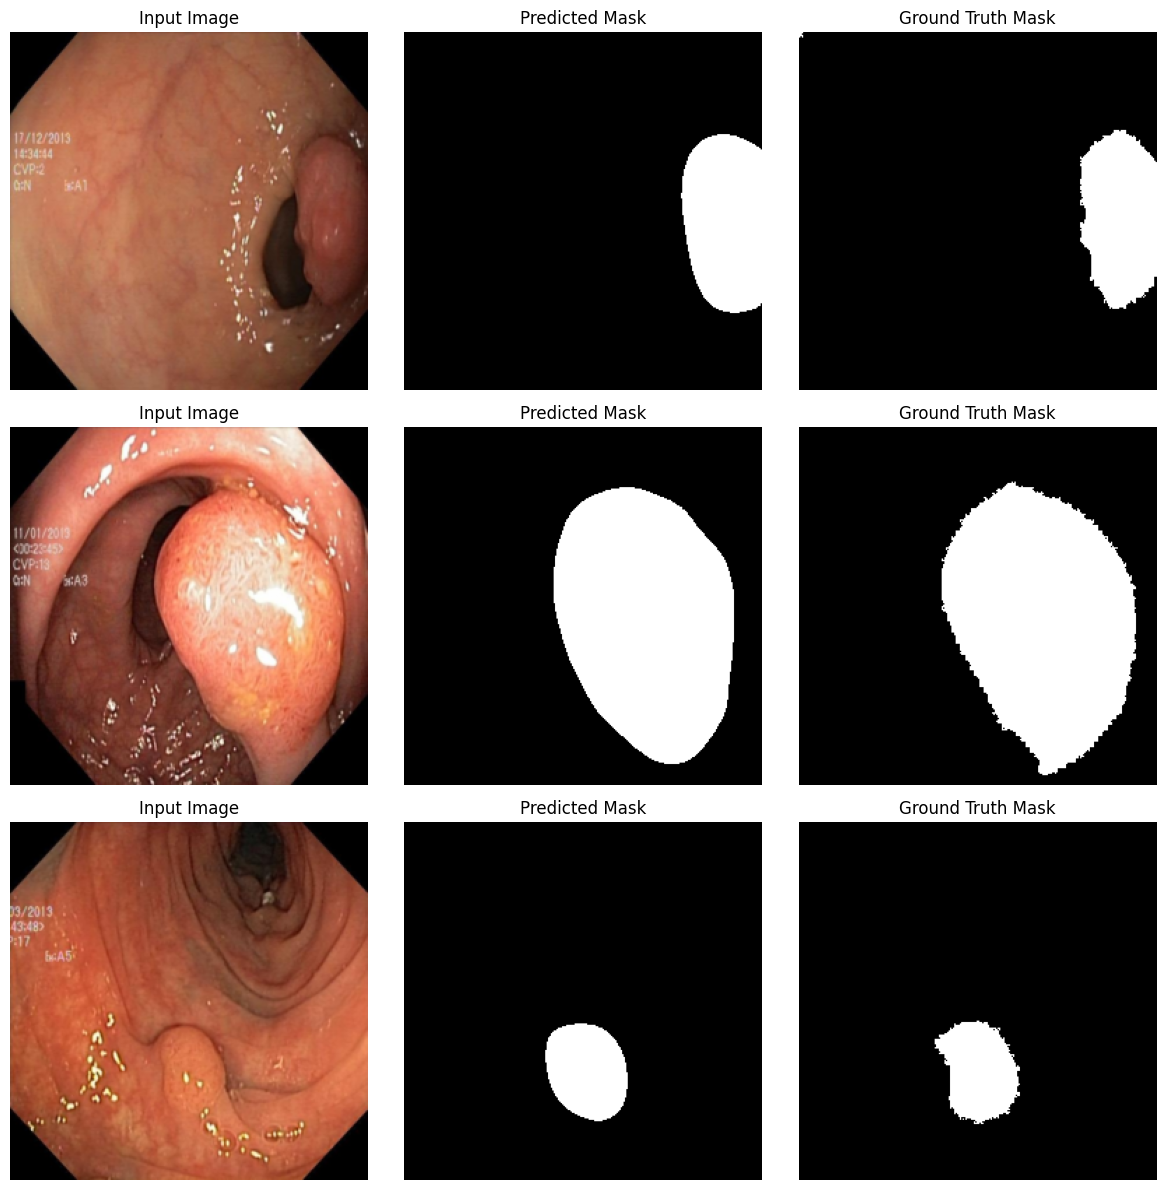

In [21]:
import torch
import matplotlib.pyplot as plt
import random

def visualize_predictions(model, dataset, device, num_samples=3):
    model.eval()
    indices = random.sample(range(len(dataset)), num_samples)

    plt.figure(figsize=(12, 4 * num_samples))

    for i, idx in enumerate(indices):
        image, mask = dataset[idx]
        image_tensor = image.unsqueeze(0).to(device)

        with torch.no_grad():
            pred = model(image_tensor)
            pred = torch.sigmoid(pred)
            pred = (pred > 0.5).float()  # thresholding

        # Move to CPU & squeeze for display
        image_np = image.permute(1, 2, 0).cpu().numpy()
        gt_mask = mask.squeeze().cpu().numpy()
        pred_mask = pred.squeeze().cpu().numpy()

        # Plot
        plt.subplot(num_samples, 3, i * 3 + 1)
        plt.imshow(image_np)
        plt.title("Input Image")
        plt.axis('off')

        plt.subplot(num_samples, 3, i * 3 + 2)
        plt.imshow(pred_mask, cmap='gray')
        plt.title("Predicted Mask")
        plt.axis('off')

        plt.subplot(num_samples, 3, i * 3 + 3)
        plt.imshow(gt_mask, cmap='gray')
        plt.title("Ground Truth Mask")
        plt.axis('off')

    plt.tight_layout()
    plt.show()

visualize_predictions(model, val_dataset, device=device)  # or 'cpu' if needed
